In [976]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
cm = plt.get_cmap('plasma')

In [977]:
# Squared exponential covariance function
def GPK(x1, x2, v, l):
    return v ** 2 * np.exp(- 0.5 * (x1[:, None] - x2[None, :]) ** 2 / l ** 2)

In [978]:
# Linear GP mean
def GPm(x, n, gamma):
    return x / n / (1 - gamma)

In [979]:
# Zero intercept
def intercept(U, x):
    i = 0
    while U[i] < 0:
        i += 1
    r = U[i - 1] / (U[i - 1] - U[i])
    return x[i - 1] + r * (x[i] - x[i - 1]), i

In [980]:
# Squared exponential GP marginal likelihood
def marg_like(params, y, x, m, snr):
    v = np.exp(params[0])
    l = np.exp(params[1])
    
    K = GPK(x, x, v, l)
    Kn = K + np.identity(len(x)) * v ** 2 / snr ** 2
    Kn_inv = np.linalg.inv(Kn)
    alpha = Kn_inv @ (y - m)
    
    return (y - m) @ alpha / 2 + np.sum(np.log(np.diag(np.linalg.cholesky(Kn)))) + len(x) * np.log(2 * np.pi) / 2

In [981]:
# Jacobian of squared exponential GP marginal likelihood
def marg_like_jac(params, y, x, m, snr):
    v = np.exp(params[0])
    l = np.exp(params[1])
    
    K = GPK(x, x, v, l)
    Kn = K + np.identity(len(x)) * v ** 2 / snr ** 2
    Kn_inv = np.linalg.inv(Kn)
    alpha = Kn_inv @ (y - m)
    
    dv = len(x) - (y - m) @ Kn_inv @ (y - m)
    
    KW = K * (Kn_inv - np.outer(alpha, alpha))
    q = x / l
    dl = q @ (KW.sum(axis=1) * q - KW @ q)
              
    return np.array([dv, dl])

In [995]:
def value_function(eff_hor, gamma=None, num=None, ran=(-10, 30), res=10, snr=1e4, maxiter=4, return_U=False):
    # Run DP from double effective horizon
    N = 2 * eff_hor
    if gamma is None:
        gamma = 1 - 1 / eff_hor
    if num is None:
        num = (ran[1] - ran[0]) * res
    Sigmas = np.linspace(*ran, num)
    
    if return_U:
        U = np.zeros((N - 1, num))
    
    # First DP step. U(N) is linear so we can compute U(N-1) directly
    s = np.sqrt(N / (N - 1))
    m = Sigmas * s ** 2
    q = Sigmas * s
    val = Sigmas / (N - 1) + (m * norm.cdf(q) + s * norm.pdf(q)) * gamma / N / (1 - gamma) 
    
    if return_U:
        U[-1,:] = val
    
    betas = []
    beta, i = intercept(val, Sigmas)
    b = []
    params = [0, 0]

    # Approximate U(n) by a GP for all subsequent steps
    for n in tqdm(range(N-1, 1, -1)):
            
        x = Sigmas[i-4:]
        y = val[i-4:num]
        
        # Remove values of Sigma larger than 4 * sqrt(n)
        if not return_U:
            upper = min(ran[1], 3 * np.sqrt(n))
            num = int((upper - ran[0]) * res)
            Sigmas = np.linspace(ran[0], upper, num)
        
        # Adapt GP hyperparameters
        params = minimize(marg_like, params, args=(y, x, GPm(x, n, gamma), snr), 
                          jac=marg_like_jac, options={'maxiter':maxiter}).x
        
        v = np.exp(params[0])
        l = np.exp(params[1])

        l2 = l ** 2
        s2 = n / (n - 1)
        s = np.sqrt(s2)
        m = s2 * Sigmas
        q = (m - beta) / s
        
        
        # Terms from the GP mean
        a1 = Sigmas / (n - 1)
        a2 = gamma * m * norm.cdf(q) / (1 - gamma) / n
        a3 = gamma * s * norm.pdf(q) / (1 - gamma) / n
        
        # GP noisy covariance matrix
        K = GPK(x, x, v, l)
        Kn = K + np.identity(len(x)) * v ** 2 / snr ** 2
        Kn_inv = np.linalg.inv(Kn)
        
        # Integral coefficients
        alpha = Kn_inv @ (y - GPm(x, n, gamma))
        
        # Terms from the GP integrals
        ss = s * l / np.sqrt(s2 + l2)
        mm = ss ** 2 * (m[:, None] / s2 + x[None, :] / l2)
        Z = v ** 2 * l * np.exp(-0.5 * (m[:, None] - x[None, :]) ** 2 / (s2 + l2)) / np.sqrt(s2 + l2)
        cdf = norm.cdf((mm - beta) / ss)
        a4 = gamma * (Z * cdf) @ alpha

        val = a1 + a2 + a3 + a4
        
        if return_U:
            U[n-2,:] = val
        
        beta, i = intercept(val, Sigmas)
        betas.append(beta)
        b.append(-beta / (n - 1))
            
    if return_U:
        return betas[::-1], b[::-1], U
    else:
        return betas[::-1], b[::-1]
        

In [996]:
betas10, b10, U10 = value_function(10, return_U=True)     # gamma = 0.9
betas20, b20, U20 = value_function(20, return_U=True)     # gamma = 0.95
betas50, b50, U50 = value_function(50, return_U=True)     # gamma = 0.98
betas100, b100, U100 = value_function(100, return_U=True) # gamma = 0.99

0.08304205186333088 1.6868260030224815
0.10076844030173704 1.961542681715171
0.133868448270673 2.8653449778065783
0.13271863113848542 2.7122147103606458
0.1472552888655322 2.691821126716547
0.15598400250839997 2.653201084181674
0.1667956502599471 2.641965249570208
0.1800527801988153 2.6224291463220877
0.1967592503202413 2.606052059693621
0.21738637191226762 2.5792589383419298
0.2433733424570817 2.5317279787377576
0.2614897226600333 2.5859338862187555
0.2943963379452378 2.514889736693842
0.3495388798811547 2.3750219404232173
0.41267208297528873 2.4673072658613426
0.452573024511549 1.936299085329259
0.5708452650055724 1.843401556127579
0.7897253679235381 1.687721648181736



0.08975382283300835 1.7467427112529699
0.11812979545013864 2.17688853862183
0.13840876315063405 3.157697688952389
0.148317640486746 3.108031959324492
0.15382777392100583 3.067681568669067
0.15366185083384873 3.011064238353896
0.16300740869609712 3.0210609145315197
0.16567332237447238 2.9927652340499398
0.16950604466881386 2.970533767002386
0.17416107280972573 2.953951440723297
0.1873204599186429 2.9916224990680726
0.19320285851274055 2.983642011014797
0.19987094778437128 2.977562171430351
0.20730274510021351 2.9734582101510547
0.2155096457071065 2.971187814541461
0.2245989655010099 2.9507418076456364
0.23469115546360905 2.9706746597646823
0.2458232985834459 2.9717265494446625
0.2582338653505166 2.9739794242913233
0.27216998302031953 2.9769353504134903
0.27438372533455835 2.9343006349202723
0.29062990010567064 2.939798679825649
0.30896740890580066 2.946457695160794
0.33002276756807064 2.953735090682558
0.3544825321520797 2.9615704154043274
0.3833540818417836 2.969577497287437
0.39570268

0.09844212406546282 1.828710688313617
0.13987173263205738 2.5786214855964786
0.1705955628357489 3.1824150229089807
0.1675208114941766 3.396142460343532
0.16827501466186798 3.4330893816883172
0.17540665252200244 3.4868947630421627
0.17870379771779327 3.4653891635820533
0.18267295679248788 3.452438052323553
0.18714955902552471 3.450958350885393
0.19207942489475105 3.4590521613653173
0.19298134613094772 3.409175721449779
0.19830823056368882 3.43029329638571
0.1998184042191445 3.3944031875616583
0.2055500264974319 3.4247526082296273
0.20733413664997444 3.3977578647228768
0.20943353680779186 3.3737273832488897
0.215562780168814 3.412481108993191
0.21775896864057417 3.394548660952868
0.2201616692822583 3.3779521540789905
0.2227322583132706 3.3634965889622515
0.2254456529246831 3.350901953043395
0.23208972806754294 3.3977123708960337
0.2348941949493521 3.3880082227745407
0.23781366862538245 3.3789607095582657
0.24085075718070553 3.3710062760189357
0.2440145971747259 3.3640829557755785
0.24729

0.10581437129402817 1.881258961887495
0.15361243683827566 2.7045234558105293
0.16746491812103342 3.1315628983556354
0.18403448323226418 3.528174840592562
0.18939297166875932 3.7112953821183425
0.195290008743903 3.801415183457802
0.20109391787582812 3.8437467494094486
0.20699134192318186 3.878665251909518
0.20985617703912157 3.843000210726398
0.21304525417942624 3.8188763234916583
0.21642527209206033 3.8060591346526627
0.22076297665960487 3.801940479521857
0.22353165807790085 3.804759441960191
0.2272048447283959 3.8132282088940803
0.22849976845058892 3.7640906386655004
0.2323184096092933 3.7794815791774585
0.23591418761559366 3.7991157776004827
0.23738798082041615 3.7636413683344565
0.24111667549208954 3.786793873447823
0.24269970814868236 3.757860347198272
0.24645779296798026 3.7848753517846476
0.24808212204633806 3.760571403159098
0.2498072623451666 3.737794381754442
0.25348036477050323 3.767838021364104
0.2552335147706365 3.749584776978857
0.2590647513438816 3.7828968665818654
0.2607

In [984]:
Sigmas = np.linspace(-10,30,400)

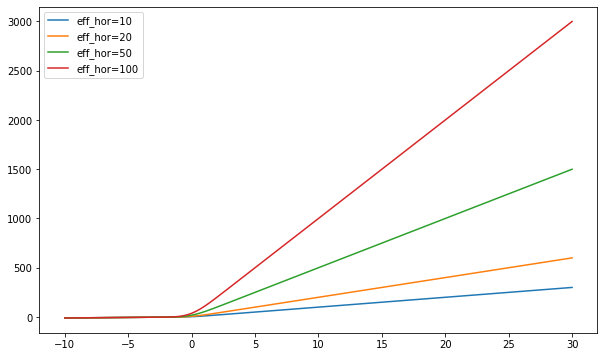

In [985]:
plt.figure(figsize=(10,6))
plt.plot(Sigmas, U10[0,:], label='eff_hor=10')
plt.plot(Sigmas, U20[0,:], label='eff_hor=20')
plt.plot(Sigmas, U50[0,:], label='eff_hor=50')
plt.plot(Sigmas, U100[0,:], label='eff_hor=100')
plt.legend()
plt.show()

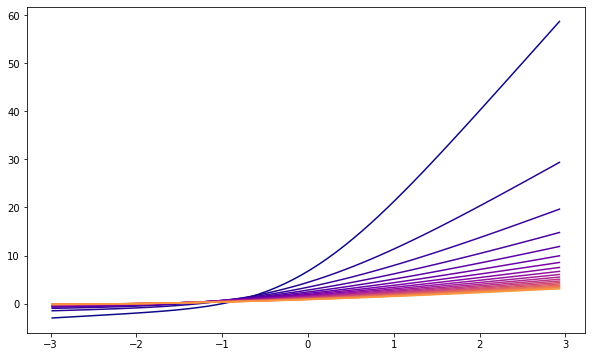

In [986]:
plt.figure(figsize=(10,6))
N=20
for i in range(N):
    plt.plot(Sigmas[70:-270], U20[i,70:-270], color=cm(0.8 * i / N))

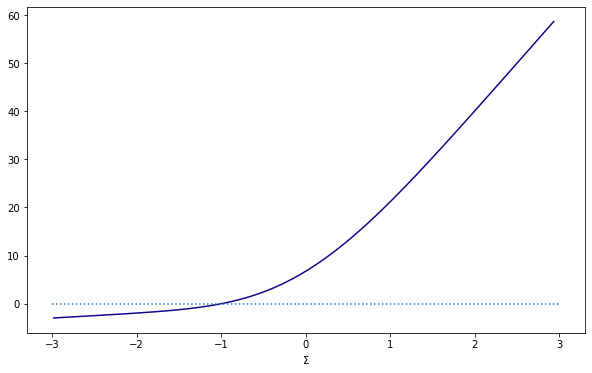

In [987]:
plt.figure(figsize=(10,6))
plt.plot(Sigmas[70:-270], U20[0,70:-270], color=cm(1))
plt.plot([-3,3],[0,0], linestyle=':')
plt.xlabel(r'$\Sigma$')
plt.show()

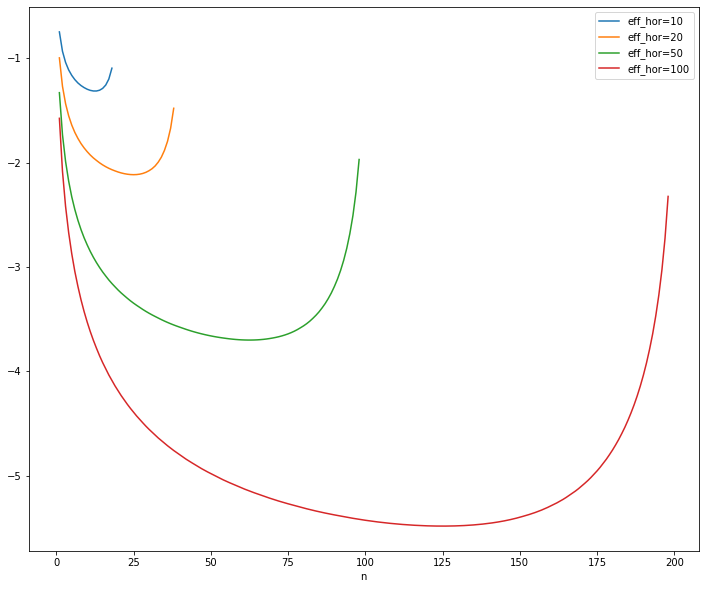

In [988]:
plt.figure(figsize=(12,10))
plt.plot(list(range(1,19)), betas10, label='eff_hor=10')
plt.plot(list(range(1,39)), betas20, label='eff_hor=20')
plt.plot(list(range(1,99)), betas50, label='eff_hor=50')
plt.plot(list(range(1,199)), betas100, label='eff_hor=100')
plt.xlabel('n')
plt.legend()
plt.show()

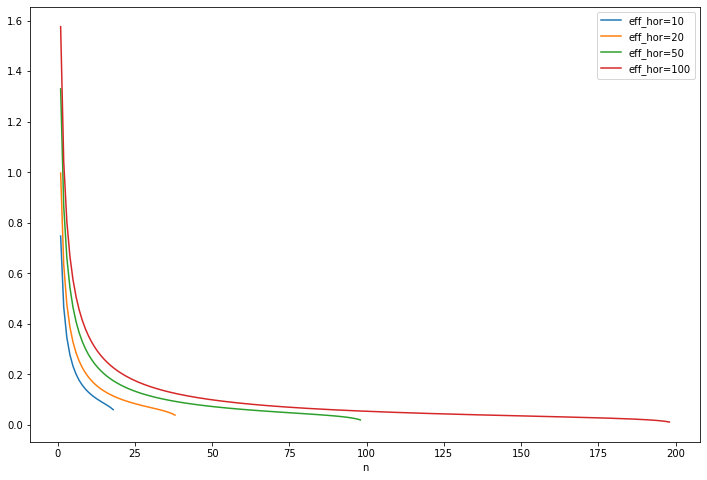

In [989]:
plt.figure(figsize=(12,8))
plt.plot(list(range(1,19)), b10, label='eff_hor=10')
plt.plot(list(range(1,39)), b20, label='eff_hor=20')
plt.plot(list(range(1,99)), b50, label='eff_hor=50')
plt.plot(list(range(1,199)), b100, label='eff_hor=100')
plt.xlabel('n')
plt.legend()
plt.show()

In [990]:
b10

[0.7476427989830694,
 0.46658841212154023,
 0.3466079542186688,
 0.277976708079031,
 0.23286219128746005,
 0.2008466485017255,
 0.17672524247972854,
 0.15774488622410837,
 0.14239013627782618,
 0.1297157958181258,
 0.11890881000182535,
 0.10948770844738102,
 0.10107380386389729,
 0.09333714389063127,
 0.08594249079340537,
 0.07856429638086122,
 0.07056791832029809,
 0.0608445045819715]

In [991]:
betas10f, b10f = value_function(10)    # gamma = 0.9
betas20f, b20f = value_function(20)    # gamma = 0.95
betas50f, b50f = value_function(50)    # gamma = 0.98
betas100f, b100f = value_function(100) # gamma = 0.99

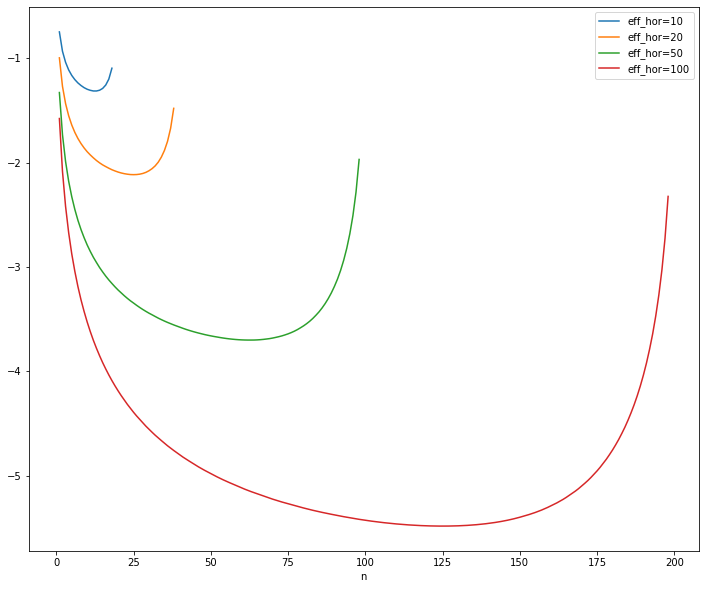

In [992]:
plt.figure(figsize=(12,10))
plt.plot(list(range(1,19)), betas10f, label='eff_hor=10')
plt.plot(list(range(1,39)), betas20f, label='eff_hor=20')
plt.plot(list(range(1,99)), betas50f, label='eff_hor=50')
plt.plot(list(range(1,199)), betas100f, label='eff_hor=100')
plt.xlabel('n')
plt.legend()
plt.show()

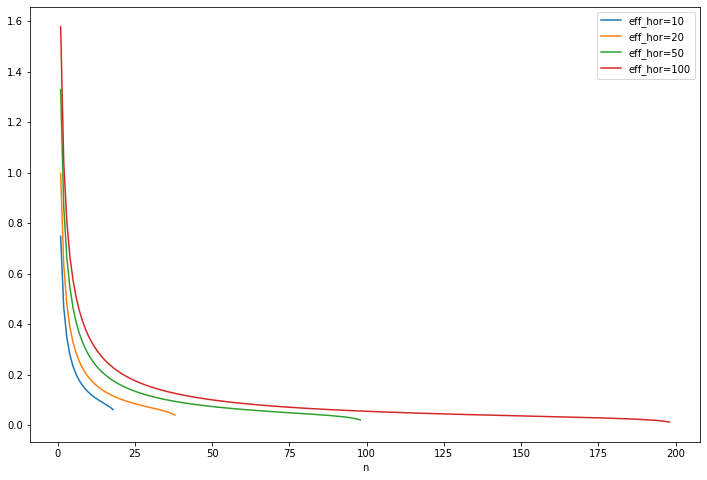

In [993]:
plt.figure(figsize=(12,8))
plt.plot(list(range(1,19)), b10f, label='eff_hor=10')
plt.plot(list(range(1,39)), b20f, label='eff_hor=20')
plt.plot(list(range(1,99)), b50f, label='eff_hor=50')
plt.plot(list(range(1,199)), b100f, label='eff_hor=100')
plt.xlabel('n')
plt.legend()
plt.show()

In [994]:
print(max([abs(b10[i]-b10f[i]) for i in range(len(b10))]))
print(max([abs(b20[i]-b20f[i]) for i in range(len(b20))]))
print(max([abs(b50[i]-b50f[i]) for i in range(len(b50))]))
print(max([abs(b100[i]-b100f[i]) for i in range(len(b100))]))

0.0002978826777711996
0.0002245316677259579
0.0011418583846709573
0.002188325988632167


In [1000]:
b100

[1.5759374838447604,
 1.0414341199951445,
 0.806570170525737,
 0.6677952930678882,
 0.5747466866540756,
 0.5073165080654081,
 0.4554036834912534,
 0.41445294590961806,
 0.38091759686917004,
 0.35291828392834085,
 0.3291356182813539,
 0.3086269582029796,
 0.29073954256793094,
 0.27509870700967065,
 0.26114130850622536,
 0.24860272015920948,
 0.23740944952785253,
 0.22715075323597647,
 0.2179233036687102,
 0.20936348605487004,
 0.20160957032318608,
 0.194363061832225,
 0.18771806308360786,
 0.181516760138957,
 0.17571214927262982,
 0.17035306572755385,
 0.1652886349470558,
 0.16052849650818993,
 0.1560968929793813,
 0.15188732170779715,
 0.14788585978299523,
 0.14415731709760318,
 0.14060672828376808,
 0.13721661223988413,
 0.13398594979183845,
 0.13095458627045392,
 0.12804904592566935,
 0.12526300387833889,
 0.12258999084929052,
 0.12006000892011812,
 0.11764093346065503,
 0.11531265897256471,
 0.11307051097392301,
 0.11091028827077017,
 0.10885077959611823,
 0.10687763164935478,
 0.10